In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import time  # For rendering delays

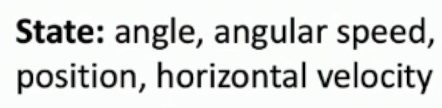

In [2]:
# Define the Q-network
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [3]:
# Define the replay buffer
class ReplayBuffer:
    def __init__(self, buffer_size):
        self.buffer = deque(maxlen=buffer_size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

In [4]:
# DQN Agent
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.learning_rate = 0.001
        self.batch_size = 64
        self.buffer_size = 10000

        self.q_network = QNetwork(state_size, action_size)
        self.target_network = QNetwork(state_size, action_size)
        self.optimizer = optim.Adam(
            self.q_network.parameters(), lr=self.learning_rate)
        self.replay_buffer = ReplayBuffer(self.buffer_size)

        # Update the target network initially
        self.update_target_network()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state).unsqueeze(0)
        q_values = self.q_network(state)
        return torch.argmax(q_values).item()

    def train(self):
        if len(self.replay_buffer) < self.batch_size:
            return

        batch = self.replay_buffer.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)

        # Compute the target Q-values
        with torch.no_grad():
            next_q_values = self.target_network(next_states).max(1)[0]
            target_q_values = rewards + \
                (self.gamma * next_q_values * (1 - dones))

        # Compute the current Q-values
        q_values = self.q_network(states).gather(
            1, actions.unsqueeze(1)).squeeze(1)

        # Compute loss and optimize
        loss = nn.MSELoss()(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [5]:
# Add this function to render the environment after training:
def render_cartpole(agent):
    env = gym.make('CartPole-v1', render_mode="human")
    state, _ = env.reset()

    while True:
        env.render()
        action = agent.get_action(state)
        state, _, done, truncated, _ = env.step(action)

        if done or truncated:
            break

    env.close()

In [6]:
def train_cartpole():
    env = gym.make('CartPole-v1')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    agent = DQNAgent(state_size, action_size)
    episodes = 1000
    target_update_freq = 10

    for episode in range(episodes):
        state, _ = env.reset()
        total_reward = 0

        while True:
            action = agent.get_action(state)
            next_state, reward, done, truncated, _ = env.step(action)
            total_reward += reward

            agent.replay_buffer.add((state, action, reward, next_state, done))
            state = next_state

            if done or truncated:
                break

            agent.train()

        # Update the target network
        if episode % target_update_freq == 0:
            agent.update_target_network()

        if episode % 100 == 1:
            print(
                f"Episode {episode}, Total Reward: {total_reward}, Epsilon: {agent.epsilon}")

    env.close()

    # Render the environment after training
    render_cartpole(agent)

In [7]:
train_cartpole()

Episode 1, Total Reward: 23.0, Epsilon: 1.0


/tmp/ipykernel_28958/760329512.py:40: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1733156786551/work/torch/csrc/utils/tensor_new.cpp:278.)
  states = torch.FloatTensor(states)


Episode 101, Total Reward: 97.0, Epsilon: 0.00998645168764533
Episode 201, Total Reward: 172.0, Epsilon: 0.00998645168764533
Episode 301, Total Reward: 102.0, Epsilon: 0.00998645168764533
Episode 401, Total Reward: 179.0, Epsilon: 0.00998645168764533
Episode 501, Total Reward: 266.0, Epsilon: 0.00998645168764533
Episode 601, Total Reward: 122.0, Epsilon: 0.00998645168764533
Episode 701, Total Reward: 171.0, Epsilon: 0.00998645168764533
Episode 801, Total Reward: 500.0, Epsilon: 0.00998645168764533
Episode 901, Total Reward: 198.0, Epsilon: 0.00998645168764533


<frozen importlib._bootstrap>:241: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.
